# Distances Test

In [1]:
import torch
import numpy as np
from sklearn.preprocessing import normalize

from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from milvus import MetricType
%matplotlib inline

# == recnn ==
import sys
sys.path.append("../../")
import recnn
from recnn.data.db_con import MilvusConnection
cuda = torch.device('cuda')

# https://drive.google.com/open?id=1t0LNCbqLjiLkAMFwtP8OIYU-zPUCNAjK
meta = json.load(open('../../data/parsed/omdb.json'))
tqdm.pandas()

/ssd/anaconda/envs/recnn/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
frame_size = 10
batch_size = 1
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
dirs = recnn.data.env.DataPath(
    base="../../data/",
    embeddings="embeddings/ml20_pca128.pkl",
    ratings="ml-20m/ratings.csv",
    cache="cache/frame_env.pkl", # cache will generate after you run
    use_cache=True
)
env = recnn.data.env.FrameEnv(dirs, frame_size, batch_size)
milvus_l2 = MilvusConnection(env, name="movies_L2", param={'metric_type':MetricType.L2})
milvus_ip = MilvusConnection(env, name="movies_IP", param={'metric_type': MetricType.IP})

In [3]:
ddpg = recnn.nn.Actor(1290, 128, 256).to(cuda)
td3 = recnn.nn.Actor(1290, 128, 256).to(cuda)

ddpg.load_state_dict(torch.load('../../models/ddpg_policy.pt'))
td3.load_state_dict(torch.load('../../models/td3_policy.pt'))


<All keys matched successfully>

In [4]:
test_batch = next(iter(env.test_dataloader))
state, action, reward, next_state, done = recnn.data.get_base_batch(test_batch)


In [5]:
ddpg_action = ddpg(state)
ddpg_action = ddpg_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 
td3_action = td3(state)
td3_action = td3_action[np.random.randint(0, state.size(0), 50)].detach().cpu().numpy() 

## Euclidean L2 Distance

In [6]:
def get_err_l2_dist(search_vecs, topk=5, search_param=None):
    if search_param is None:
        search_param = dict()
    search_param = {"nprobe": 16, **search_param}
    status, results = milvus_l2.client.search(
        collection_name=milvus_l2.name,
        query_records=search_vecs,
        top_k=topk,
        params=search_param,
    )
    D = np.array(results.distance_array)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return results.id_array, mean, std

In [7]:
ddpg_I, ddpg_mean, ddpg_std = get_err_l2_dist(ddpg_action, 10)
td3_I, td3_mean, td3_std = get_err_l2_dist(td3_action, 10)

labels = ['DDPG', 'TD3']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean]
error = [ddpg_std, td3_std]

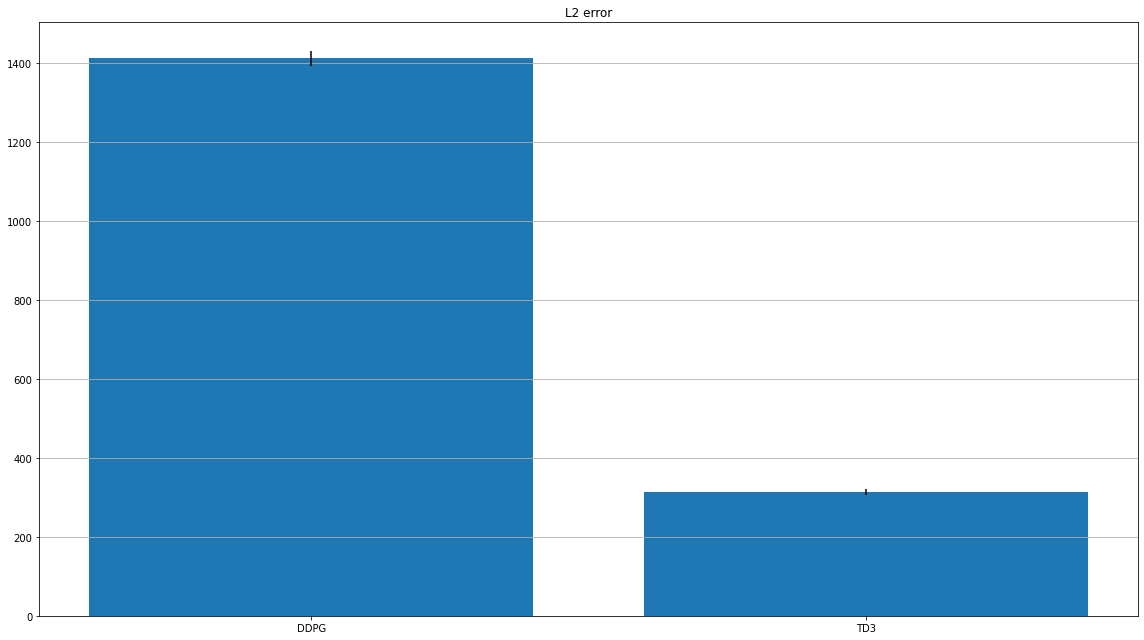

In [8]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('L2 error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

### Recommended movie similarities

In [9]:
mov_mat = env.base.embeddings.clone().detach()
action = np.random.randint(0, 50, 1)[0]

recnn.utils.pairwise_distances(torch.tensor(mov_mat[ddpg_I][action]))
recnn.utils.pairwise_distances(torch.tensor(mov_mat[td3_I][action]))

<ipython-input-9-384f7935d109>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recnn.utils.pairwise_distances(torch.tensor(mov_mat[ddpg_I][action]))
/ssd/programming/python/RecNN/recnn/utils/plot.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-9-384f7935d109>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recnn.utils.pairwise_distances(torch.tensor(mov_mat[td3_I][action]))


## InnerProduct Distance
### bigger = better

In [10]:
def get_err_ip_dist(search_vecs, topk=5, search_param=None):
    if search_param is None:
        search_param = dict()
    search_param = {"nprobe": 16, **search_param}
    status, results = milvus_ip.client.search(
        collection_name=milvus_ip.name,
        query_records=search_vecs,
        top_k=topk,
        params=search_param,
    )
    D = np.array(results.distance_array)
    mean = D.mean(axis=1).mean()
    std  = D.std(axis=1).mean()
    return results.id_array, mean, std

In [11]:
ddpg_I, ddpg_mean, ddpg_std = get_err_ip_dist(ddpg_action, 10)
td3_I, td3_mean, td3_std = get_err_ip_dist(td3_action, 10)

labels = ['DDPG', 'TD3']
x_pos = np.arange(len(labels))
CTEs = [ddpg_mean, td3_mean]
error = [ddpg_std, td3_std]

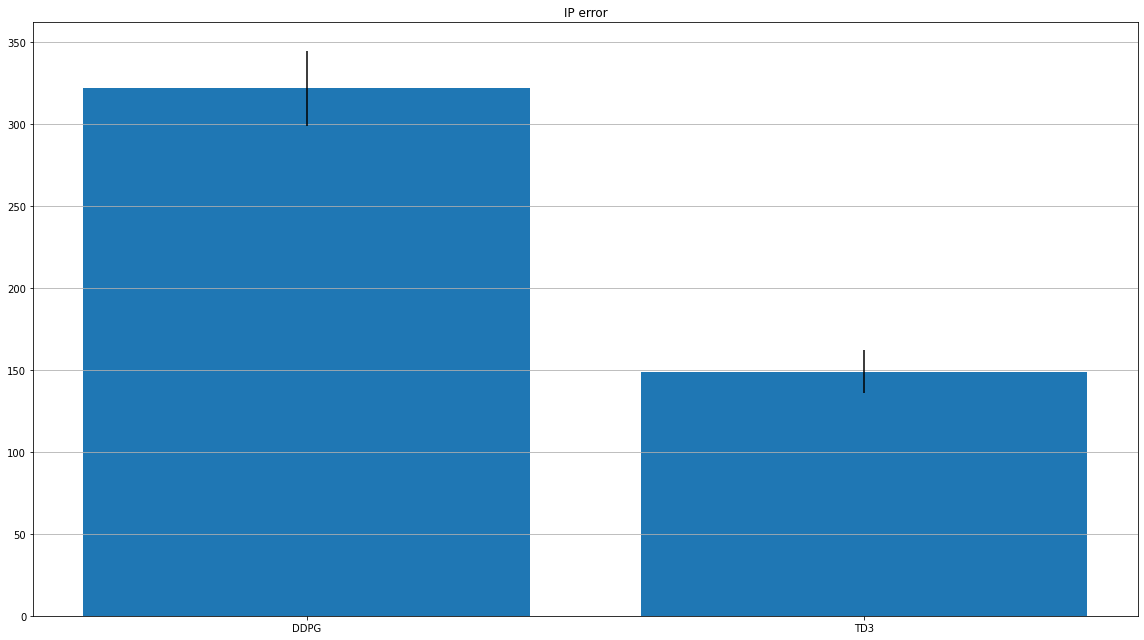

In [12]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('IP error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

In [13]:
# normalization test
np.allclose(np.linalg.norm(normalize(ddpg_action, axis=1, norm='l2'), axis=1), 1)

True

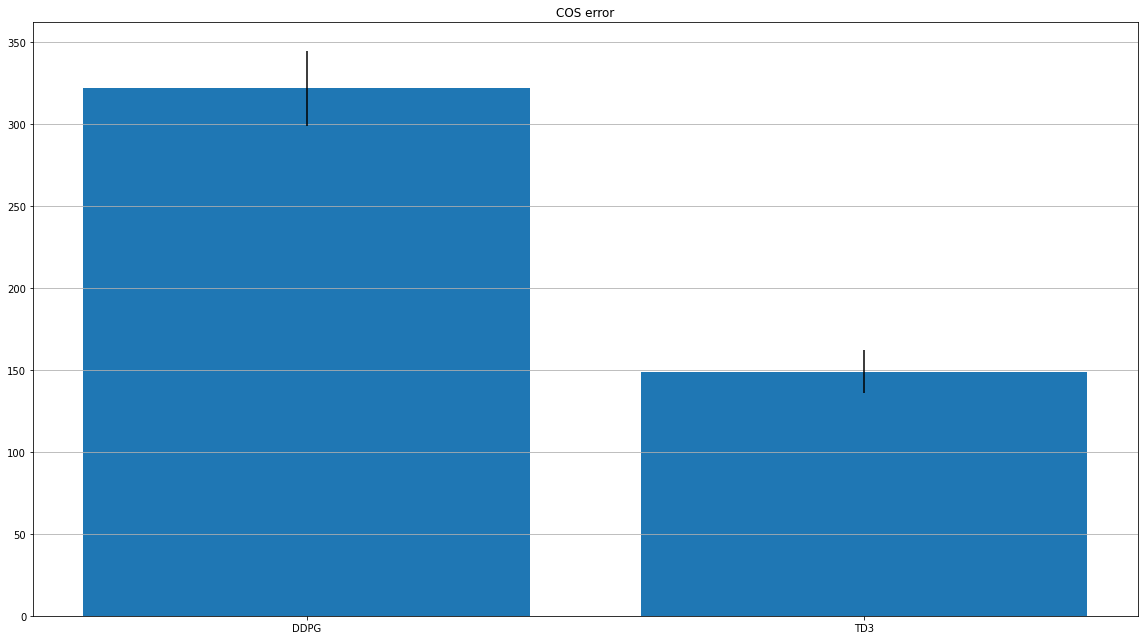

In [14]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.bar(x_pos, CTEs,yerr=error,)
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('COS error')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.show()

### Recommended movies similarities

In [15]:
action = np.random.randint(0, 50, 1)[0]

recnn.utils.pairwise_distances(torch.tensor(mov_mat[ddpg_I][action]))
recnn.utils.pairwise_distances(torch.tensor(mov_mat[td3_I][action]))

<ipython-input-15-c4f77098874e>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recnn.utils.pairwise_distances(torch.tensor(mov_mat[ddpg_I][action]))
/ssd/programming/python/RecNN/recnn/utils/plot.py:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-15-c4f77098874e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recnn.utils.pairwise_distances(torch.tensor(mov_mat[td3_I][action]))
